In [1]:
from fastkaggle import *
from fastai import *
from fastai.tabular.all import *
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from xgboost import XGBRegressor
import warnings

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [2]:
#fastkaggle setup
comp = "store-sales-time-series-forecasting"

path = setup_comp(comp)
print(f"Competition Path: {path}")

holiday_events_df = pd.read_csv(path/'holidays_events.csv', low_memory=False)
oil_df = pd.read_csv(path/'oil.csv', low_memory=False)
stores_df = pd.read_csv(path/'stores.csv', low_memory=False)
test_df = pd.read_csv(path/'test.csv', low_memory=False)
train_df = pd.read_csv(path/'train.csv', low_memory=False)
transactions_df = pd.read_csv(path/'transactions.csv', low_memory=False)


#correct datetimes
add_datepart(train_df, 'date')
add_datepart(test_df, 'date')
drop_cols = ['id', 'Elapsed']
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

#categorize familys
# train_df['family'] = train_df['family'].astype("category")
# train_df['family'] = train_df.family.cat.codes
train_df['family'] = pd.Categorical(train_df.family)
test_df['family'] = pd.Categorical(test_df.family)


#correct datatypes
# train_df.onpromotion = train_df.onpromotion.astype("float16")
# train_df.sales = train_df.sales.astype("float32")
# stores_df.cluster = stores_df.cluster.astype("int8")

#Setup Databased Variables
dep_var = 'sales'
train_df[dep_var] = np.log(train_df[dep_var]+1)

#condition for validation/training dataset split
condition = lambda df: (df.Year < 2017)
train_idx = np.where(condition(train_df))[0]
valid_idx = np.where(~(condition(train_df)))[0]
splits = (list(train_idx), list(valid_idx))



Competition Path: store-sales-time-series-forecasting


## FastAI's TabularPandas + TabularProc

In [3]:
procs = [Categorify, FillMissing, Normalize]
cont_vars, cat_vars = cont_cat_split(train_df, 1, dep_var=dep_var)
to = TabularPandas(train_df, procs, cat_vars, cont_vars, y_names=dep_var, splits=splits)
print(f"Training Set Size: {len(to.train)}\nValidation Set Size: {len(to.valid)}")
print(f"cont vars: {cont_vars}\ncat vars: {cat_vars}")
save_pickle(path/'training_set.pkl', to)

Training Set Size: 2596374
Validation Set Size: 404514
cont vars: ['store_nbr', 'onpromotion', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
cat vars: ['family', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']


In [4]:
to = load_pickle(path/'training_set.pkl')

In [5]:
x_train_vars, y_train_vars = to.train.xs, to.train.y
x_valid_vars, y_valid_vars = to.valid.xs, to.valid.y

In [6]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [7]:
rf_m = rf(x_train_vars, y_train_vars, 45)
m_rmse(rf_m, x_train_vars, y_train_vars), m_rmse(rf_m, x_valid_vars, y_valid_vars)

(0.619317, 0.6913)

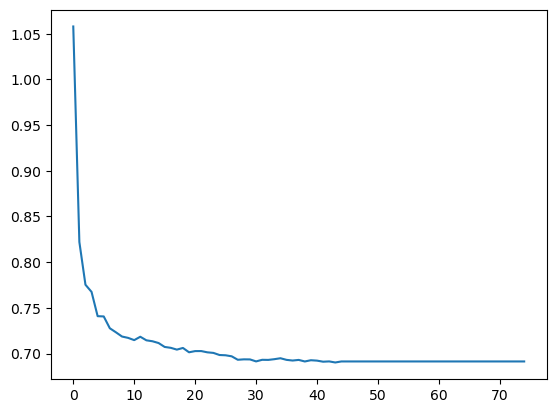

In [8]:
warnings.filterwarnings("ignore", category=UserWarning)

preds = np.stack([t.predict(x_valid_vars) for t in rf_m.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), y_valid_vars) for i in range(75)]);

In [9]:
#out of bag error checking
r_mse(rf_m.oob_prediction_, y_train_vars)

0.635431

### Data Examination

             cols       imp
0          family  0.521865
8     onpromotion  0.254251
7       store_nbr  0.135697
9            Year  0.038428
14      Dayofyear  0.016727
13      Dayofweek  0.009608
11           Week  0.008874
12            Day  0.006673
10          Month  0.006250
6   Is_year_start  0.001128


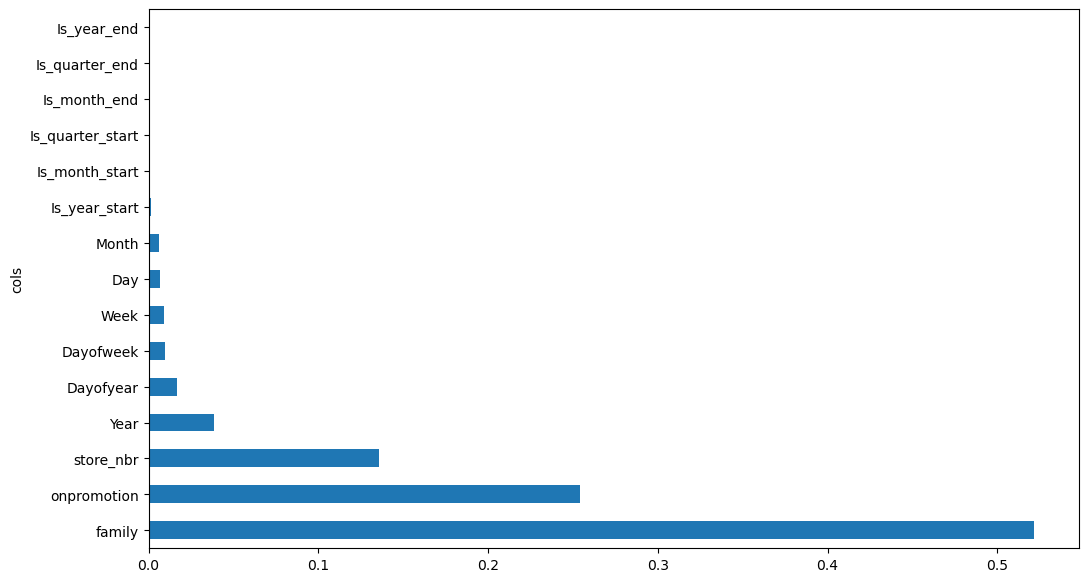

In [10]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_feat_imp(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)


fi = rf_feat_importance(rf_m, x_train_vars)
print(fi[:10])

plot_feat_imp(fi[:30]);



In [11]:
from sklearn.tree import export_graphviz
from scipy.cluster import hierarchy as hc

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

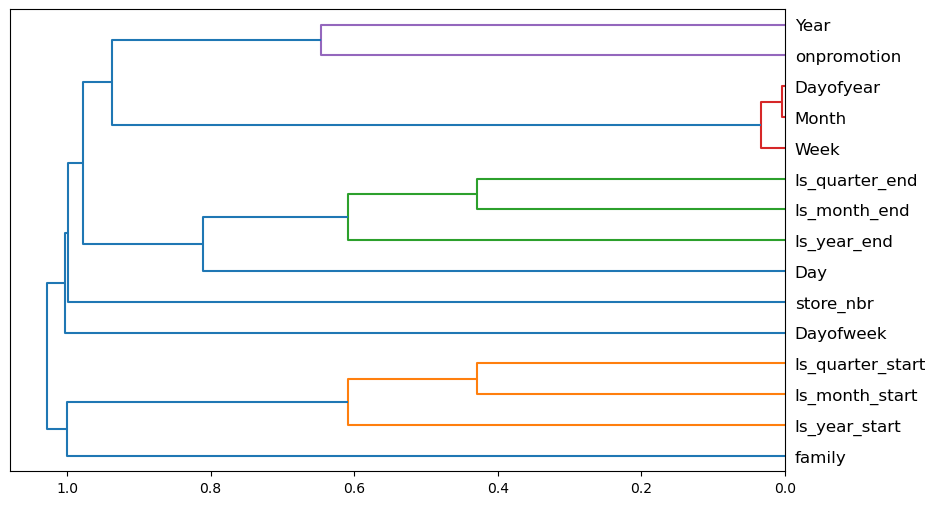

In [12]:
cluster_columns(x_train_vars)

# Adding in the Metadata

In [13]:
og_test_df = pd.read_csv(path/'test.csv', low_memory=False)
og_train_df = pd.read_csv(path/'train.csv', low_memory=False)

def merge_data(df: pd.DataFrame) -> pd.DataFrame:
    #merge in oil data, filling missing values
    new_df = df.merge(oil_df, on='date', how='left')
    new_df = new_df.merge(holiday_events_df, on='date', how='left')
    new_df = new_df.merge(stores_df, on='store_nbr', how='left')
    new_df = new_df.merge(transactions_df, on=['date', 'store_nbr'], how='left')
    return new_df

In [14]:
small = og_train_df.merge(oil_df, on='date', how='left')
# print(small.loc[small['dcoilwtico'].notna()])
print(small.iloc[[0]], '\n',small.iloc[[1782]])

   id        date  store_nbr      family  sales  onpromotion  dcoilwtico
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0         NaN 
         id        date  store_nbr      family  sales  onpromotion  dcoilwtico
1782  1782  2013-01-02          1  AUTOMOTIVE    2.0            0       93.14


In [15]:
full_train_df = merge_data(og_train_df)
full_test_df = merge_data(og_test_df)

In [ ]:
#full_train_df.to_csv("./store-sales-time-series-forecasting/full_train.csv")
add_datepart(full_train_df, 'date')
add_datepart(full_test_df, 'date')

In [24]:
full_train_df['family'] = pd.Categorical(full_train_df.family)
full_test_df['family'] = pd.Categorical(full_test_df.family)
full_train_df[dep_var] = np.log(full_train_df[dep_var]+1)

/home/carson/mambaforge/envs/fastai/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Cleaning up the Metadata

In [34]:
oil = oil_df.copy()
pd.isnull(oil).any().notnull()
pd.

date          True
dcoilwtico    True
dtype: bool